**Câu hỏi:** Làm thế nào để dự đoán doanh thu toàn cầu của một bộ phim?<br>
**Ý nghĩa:** Xác định các yếu tố quan trọng nhất liên quan đến doanh thu toàn cầu của một bộ phim, như mối liên hệ giữa số lượng đánh giá (vote_count) và điểm trung bình (vote_average) với thành công của bộ phim, thể loại phim (genre) nào thường tạo ra doanh thu cao nhất, và thời lượng phim (runtime) có ảnh hưởng đến doanh thu hay không.<br>
Dự đoán doanh thu toàn cầu giúp nhà sản xuất, nhà đầu tư và nhà phát hành hiểu rõ các yếu tố ảnh hưởng đến thành công tài chính của một bộ phim. Từ đó, họ có thể tối ưu hóa ngân sách, chọn thể loại phù hợp, điều chỉnh thời lượng phim, và xây dựng chiến lược marketing hiệu quả để tăng khả năng thành công.

In [39]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


### Đọc dữ liệu từ file csv

In [40]:
data = pd.read_csv('../data/cleaned_movies_no_outliers.csv')
threshold = 2.5
data['is_profitable'] = data['worldwide'] > threshold * data['budget']
data.drop(columns=['worldwide', 'domestic', 'international'], inplace=True)
genre_columns = [col for col in data.columns if col.startswith('genre_')]
data_no_genre = data.copy()
data_no_genre = data_no_genre.drop(columns=genre_columns)
data = data.select_dtypes(include=[np.number, np.bool_])
data_no_genre = data_no_genre.select_dtypes(include=[np.number, np.bool_])

### Ma trận tương quan

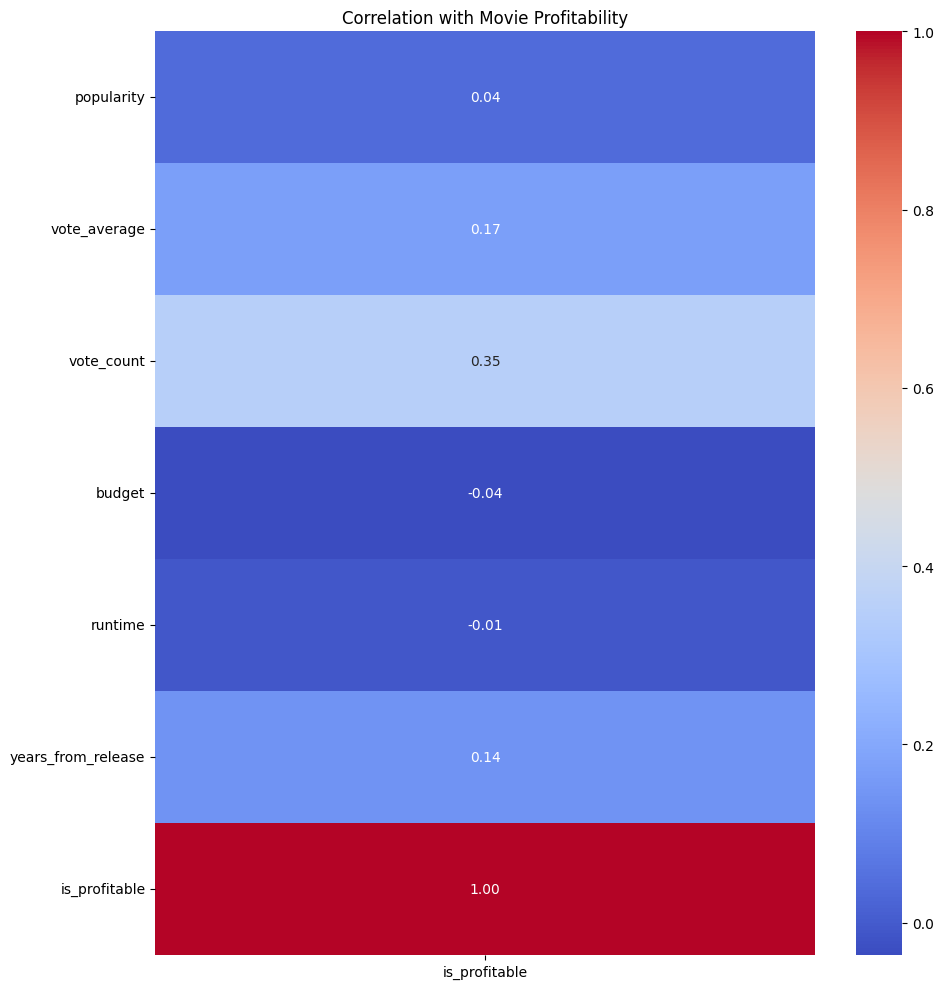

In [41]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_no_genre.corr()[['is_profitable']], 
            annot=True,
            cmap='coolwarm',
            fmt='.2f')
plt.title('Correlation with Movie Profitability')
plt.tight_layout()
plt.show()

Ma trận tương quan này thể hiện hệ số tương quan giữa các thuộc tính phim khác nhau và biến mục tiêu **"is_profitable"** (có sinh lời hay không).

**Các điểm chính:**

*   **`vote_count`** (0.35) có tương quan thuận **mạnh nhất** với `is_profitable`, cho thấy phim có nhiều phiếu bầu hơn có xu hướng sinh lời cao hơn.
*   **`vote_average`** (0.17) có tương quan thuận **vừa phải**, ngụ ý rằng điểm đánh giá trung bình cao hơn có liên quan đến khả năng sinh lời.
*   **`years_from_release`** (0.14) cho thấy phim càng mới thì có xu hướng có khả năng sinh lời cao hơn (tương quan thuận yếu)
*   **`budget`** (-0.038) có tương quan nghịch **rất yếu**, gần như không đáng kể, cho thấy ngân sách phim không ảnh hưởng nhiều đến khả năng sinh lời trong trường hợp này.

**Nhìn chung, `vote_count`, `vote_average` và `years_from_release` cho thấy mối tương quan đáng chú ý nhất với khả năng sinh lời của phim trong tập dữ liệu này.**

### Xáo trộn data

In [42]:
data = data.sample(frac=1, random_state=0) 
data

,popularity,vote_average,vote_count,budget,runtime,years_from_release,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,...,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,is_profitable
1188,40.539,5.600,657,51000000,93,18,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1294,34.925,7.700,18668,170000000,136,10,True,True,False,False,...,False,False,False,False,True,False,False,False,False,True
963,44.022,7.364,5655,200000000,127,3,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
98,139.830,8.084,9245,100000000,181,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1364,36.804,5.600,3371,80000000,104,16,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,62.042,7.680,5781,22000000,113,4,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1731,24.929,7.381,2550,30000000,133,30,True,False,False,False,...,False,False,False,True,False,False,False,True,True,True
763,53.558,6.300,3100,146000000,131,2,True,True,False,False,...,False,False,False,False,True,False,False,False,False,False
835,50.896,7.800,5389,40000000,87,15,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False


### Tách dữ liệu thành các tập train, test vầ valid

In [43]:
split_points = [0.6, 0.8]
train = data.iloc[:int(split_points[0]*len(data))]
valid = data.iloc[int(split_points[0]*len(data)):int(split_points[1]*len(data))]
test = data.iloc[int(split_points[1]*len(data)):]

### Bỏ đi cột 'is_profitable' cho việc dự đoán

In [44]:
train_X = train.drop(columns=['is_profitable'])
train_y = train['is_profitable']
valid_X = valid.drop(columns=['is_profitable'])
valid_y = valid['is_profitable']
test_X = test.drop(columns=['is_profitable'])
test_y = test['is_profitable']

## Tinh chỉnh siêu tham số cho với GridSearchCV

Đoạn mã này sử dụng `GridSearchCV` để tìm bộ siêu tham số tốt nhất cho mô hình `LogisticRegression`.

**Các bước chính:**

1. **`param_grid`:** Định nghĩa các giá trị siêu tham số cần thử (`C`, `penalty`, `solver`).
2. **`LogisticRegression(max_iter=2000, random_state=42)`:** Khởi tạo mô hình Logistic Regression.
3. **`GridSearchCV(...)`:** Tìm kiếm tổ hợp siêu tham số tốt nhất dựa trên `accuracy` sử dụng kiểm định chéo 5-fold (5-fold cross-validation).
4. **`grid_search.fit(train_X, train_y)`:** Huấn luyện mô hình với các tổ hợp siêu tham số.
5. **`best_params` và `best_lr`:** Lấy ra siêu tham số tốt nhất và mô hình tốt nhất.
6. **`accuracy_score(...)`:** Đánh giá mô hình trên tập validation bằng `accuracy`.

In [45]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logreg = LogisticRegression(max_iter=2000, random_state=42)
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_
best_lr = grid_search.best_estimator_
print("Best Parameters:", best_params)
pred_y_valid = best_lr.predict(valid_X)
accuracy = accuracy_score(valid_y, pred_y_valid)
print("Test Accuracy On Validation Dataset:: ", accuracy)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy On Validation Dataset::  0.7240618101545254


### Trực quan hóa kết quả Logistic Regression


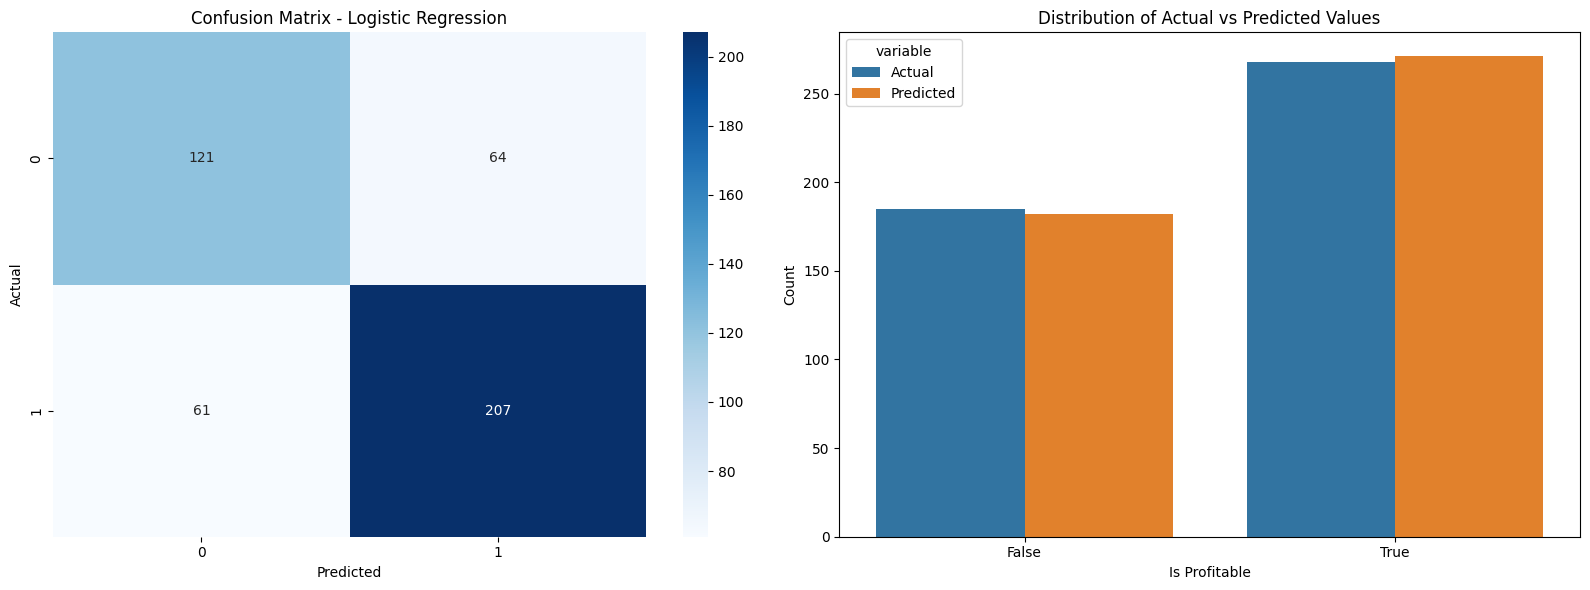

In [46]:
cm = confusion_matrix(valid_y, pred_y_valid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix - Logistic Regression")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

comparison_df = pd.DataFrame({
    'Actual': valid_y,
    'Predicted': pred_y_valid
})
sns.countplot(data=pd.melt(comparison_df), 
              x='value', 
              hue='variable',
              ax=ax2)
ax2.set_title("Distribution of Actual vs Predicted Values")
ax2.set_xlabel("Is Profitable")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()



Đoạn mã này sử dụng `GridSearchCV` để tìm bộ siêu tham số tốt nhất cho mô hình `RandomForestClassifier`.

**Các bước chính:**

1. **`param_grid`:** Định nghĩa các giá trị siêu tham số cần thử (`n_estimators`, `max_depth`, `bootstrap`).
    *   `n_estimators`: Số lượng cây trong rừng.
    *   `max_depth`: Độ sâu tối đa của cây. `None` nghĩa là không giới hạn.
    *   `bootstrap`:  Có sử dụng kỹ thuật bootstrapping (lấy mẫu có hoàn lại) hay không.
2. **`RandomForestClassifier(random_state=42)`:** Khởi tạo mô hình Random Forest.
3. **`GridSearchCV(...)`:** Tìm kiếm tổ hợp siêu tham số tốt nhất dựa trên `accuracy` sử dụng kiểm định chéo 5-fold (5-fold cross-validation).
4. **`grid_search.fit(train_X, train_y)`:** Huấn luyện mô hình với các tổ hợp siêu tham số.
5. **`best_params` và `best_rf`:** Lấy ra siêu tham số tốt nhất và mô hình tốt nhất.
6. **`accuracy_score(...)`:** Đánh giá mô hình trên tập validation bằng `accuracy`.

In [47]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
print("Best Parameters:", best_params)
pred_y_valid = best_rf.predict(valid_X)
accuracy = accuracy_score(valid_y, pred_y_valid)
print("Test Accuracy On Validation Dataset:", accuracy)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 200}
Test Accuracy On Validation Dataset: 0.717439293598234


### Trực quan hóa kết quả Random Forest Classifier


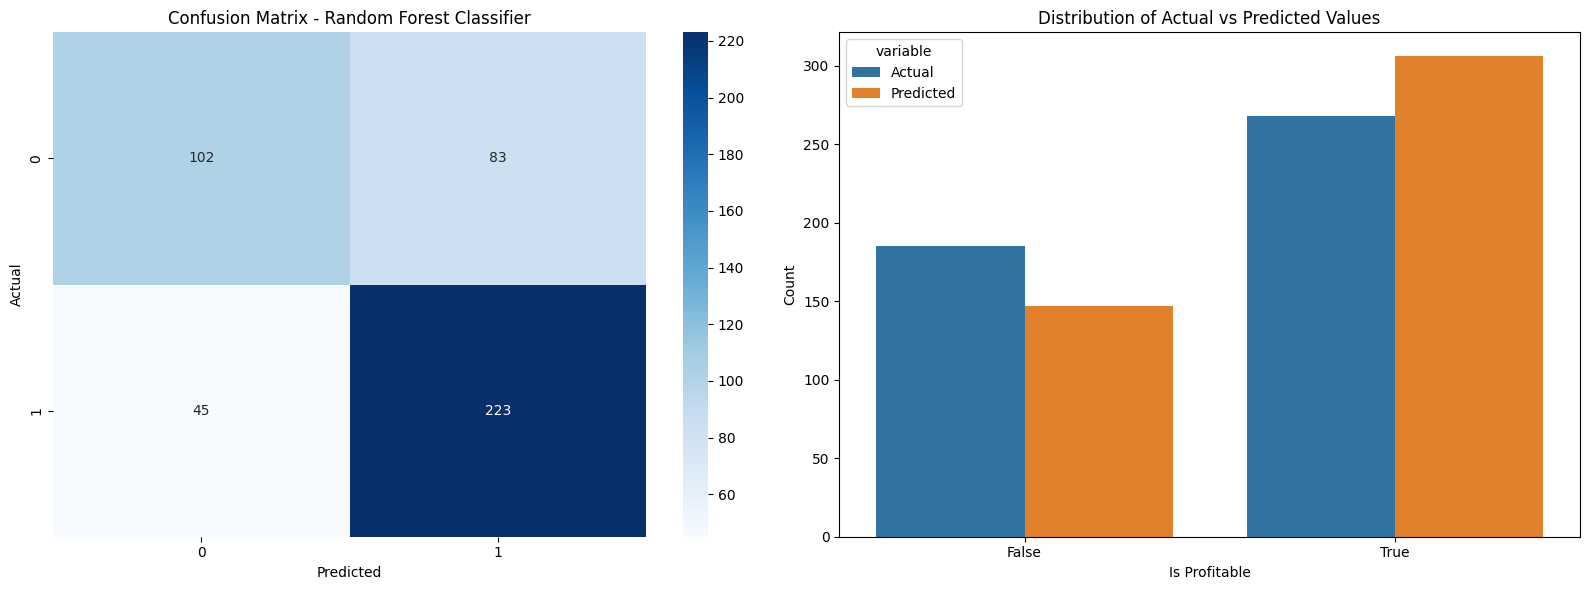

In [48]:
cm = confusion_matrix(valid_y, pred_y_valid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix - Random Forest Classifier")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

comparison_df = pd.DataFrame({
    'Actual': valid_y,
    'Predicted': pred_y_valid
})
sns.countplot(data=pd.melt(comparison_df), 
              x='value', 
              hue='variable',
              ax=ax2)
ax2.set_title("Distribution of Actual vs Predicted Values")
ax2.set_xlabel("Is Profitable")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()



Đoạn mã này sử dụng `GridSearchCV` để tìm bộ siêu tham số tốt nhất cho mô hình `GradientBoostingClassifier`.

**Các bước chính:**

1. **`param_grid`:** Định nghĩa các giá trị siêu tham số cần thử (`learning_rate`, `n_estimators`).
    *   `learning_rate`: Tốc độ học (learning rate), kiểm soát mức độ đóng góp của mỗi cây.
    *   `n_estimators`: Số lượng cây (boosting stages).
2. **`GradientBoostingClassifier(random_state=42)`:** Khởi tạo mô hình Gradient Boosting.
3. **`GridSearchCV(...)`:** Tìm kiếm tổ hợp siêu tham số tốt nhất dựa trên `accuracy` sử dụng kiểm định chéo 5-fold (5-fold cross-validation).
4. **`grid_search.fit(train_X, train_y)`:** Huấn luyện mô hình với các tổ hợp siêu tham số.
5. **`best_params` và `best_gb`:** Lấy ra siêu tham số tốt nhất và mô hình tốt nhất.
6. **`accuracy_score(...)`:** Đánh giá mô hình trên tập validation bằng `accuracy`.

In [49]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_
best_gb = grid_search.best_estimator_
print("Best Parameters:", best_params)
pred_y_valid = best_gb.predict(valid_X)
accuracy = accuracy_score(valid_y, pred_y_valid)
print("Test Accuracy On Validation Dataset:", accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 200}
Test Accuracy On Validation Dataset: 0.7306843267108167


### Trực quan hóa kết quả Gradient Boosting Classifier

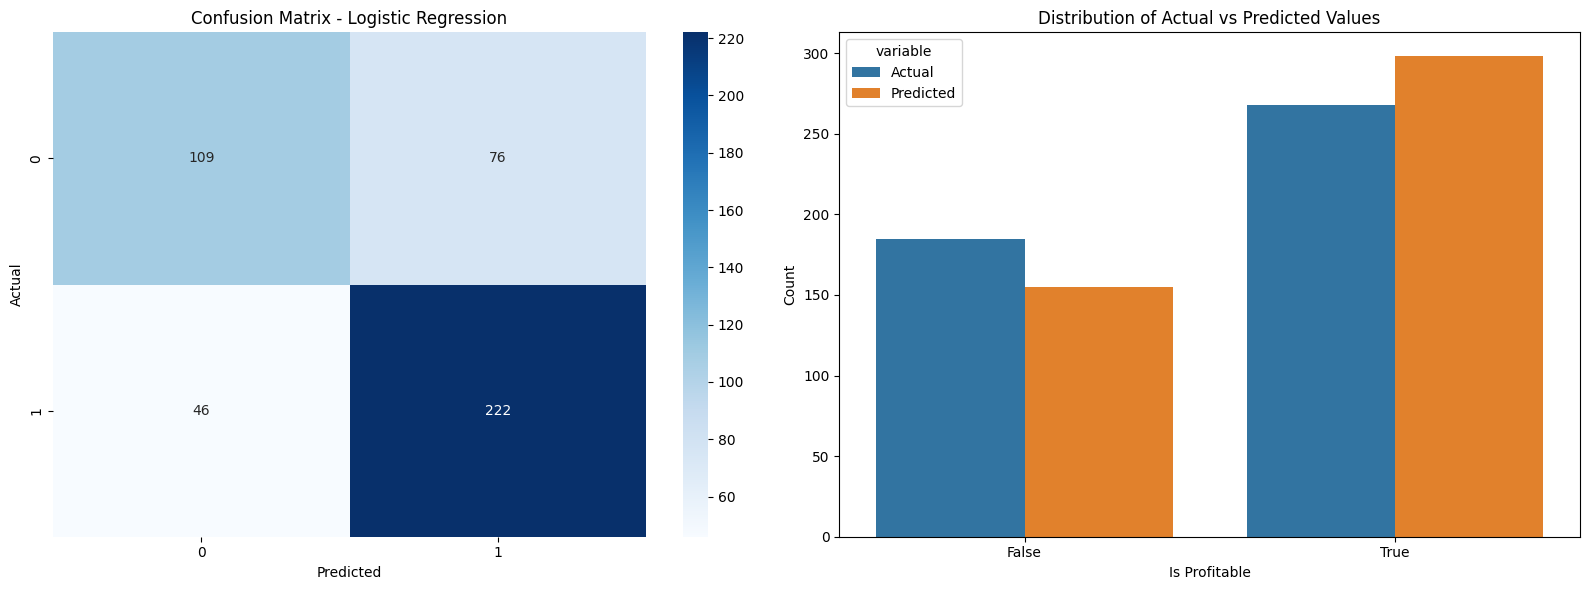

In [50]:
cm = confusion_matrix(valid_y, pred_y_valid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix - Logistic Regression")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

comparison_df = pd.DataFrame({
    'Actual': valid_y,
    'Predicted': pred_y_valid
})
sns.countplot(data=pd.melt(comparison_df), 
              x='value', 
              hue='variable',
              ax=ax2)
ax2.set_title("Distribution of Actual vs Predicted Values")
ax2.set_xlabel("Is Profitable")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()



## So sánh kết quả

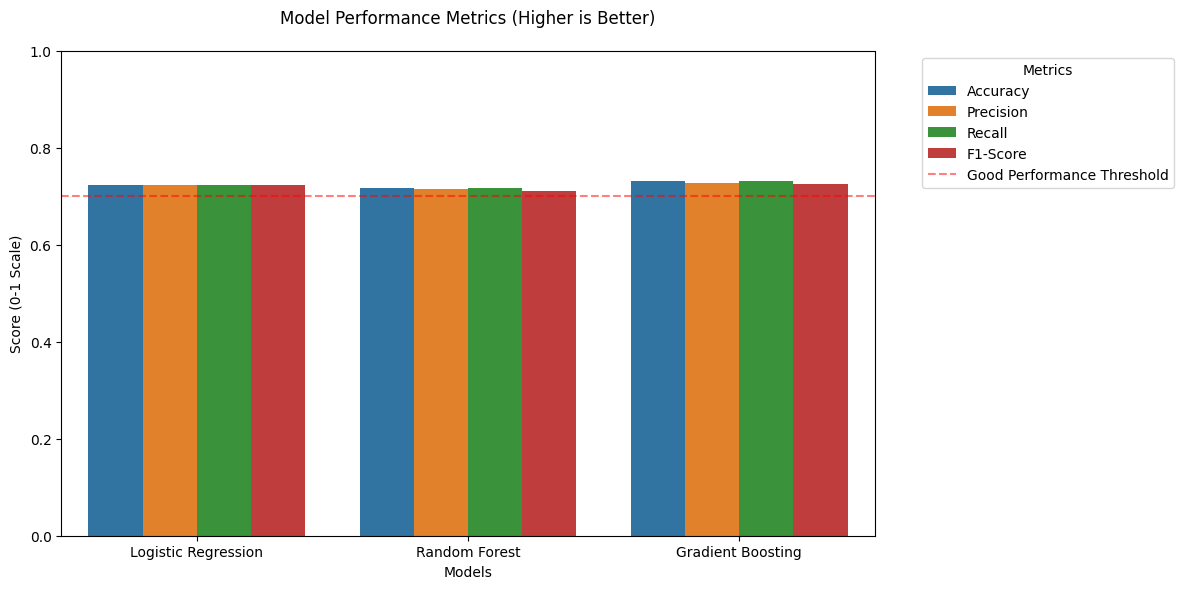

In [51]:
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb
}

results = []
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for name, model in models.items():
    pred_y_valid = model.predict(valid_X)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(valid_y, pred_y_valid),  
        'Precision': precision_score(valid_y, pred_y_valid, average='weighted'),  
        'Recall': recall_score(valid_y, pred_y_valid, average='weighted'),  
        'F1-Score': f1_score(valid_y, pred_y_valid, average='weighted')  
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
results_melted = pd.melt(results_df, id_vars=['Model'], value_vars=metrics)

sns.barplot(data=results_melted, x='Model', y='value', hue='variable')
plt.title('Model Performance Metrics (Higher is Better)', pad=20)
plt.xlabel('Models')
plt.ylabel('Score (0-1 Scale)')

plt.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Good Performance Threshold')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1))
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### Tìm mô hình tốt nhất

So sánh **Logistic Regression (`best_lr`)**, **Random Forest (`best_rf`)**, và **Gradient Boosting (`best_gb`)** sau khi chuẩn hóa dữ liệu bằng `StandardScaler` thông qua `Pipeline` và `GridSearchCV`.

**Các bước chính:**

1. **`Pipeline(...)`:** Tạo pipeline gồm `StandardScaler` và `classifier` (trình giữ chỗ cho mô hình).
2. **`param_grid`:** Chỉ định từng mô hình (`best_lr`, `best_rf`, `best_gb`) cho bước `classifier` trong `Pipeline`.
3. **`GridSearchCV(...)`:** Tìm mô hình tốt nhất trong `param_grid` dựa trên `accuracy` sử dụng k-fold cross validation
4. **`grid_search.fit(...)`:** Huấn luyện `Pipeline` với các mô hình.
5. **`print("Best Model:", ...)`:** In ra mô hình tốt nhất.
6. **`best_pipeline = ...`:** Lấy ra `Pipeline` tốt nhất.
7. **`best_pipeline.fit(...)`:** Huấn luyện lại `Pipeline` tốt nhất.

In [52]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', None)  
])

param_grid = [
    {
        'classifier': [best_lr],
    },
    {
        'classifier': [best_rf],
    },
    {
        'classifier': [best_gb],
    },
]

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

print("Best Model:", grid_search.best_params_['classifier'])
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(train_X, train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Model: GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=200,
                                            random_state=42))])

### Đánh giá mô hình tốt nhất trên tập dữ liệu kiểm tra

Test Accuracy On Validation Dataset: 0.7306843267108167
Test Accuracy On Test Dataset: 0.7328918322295805


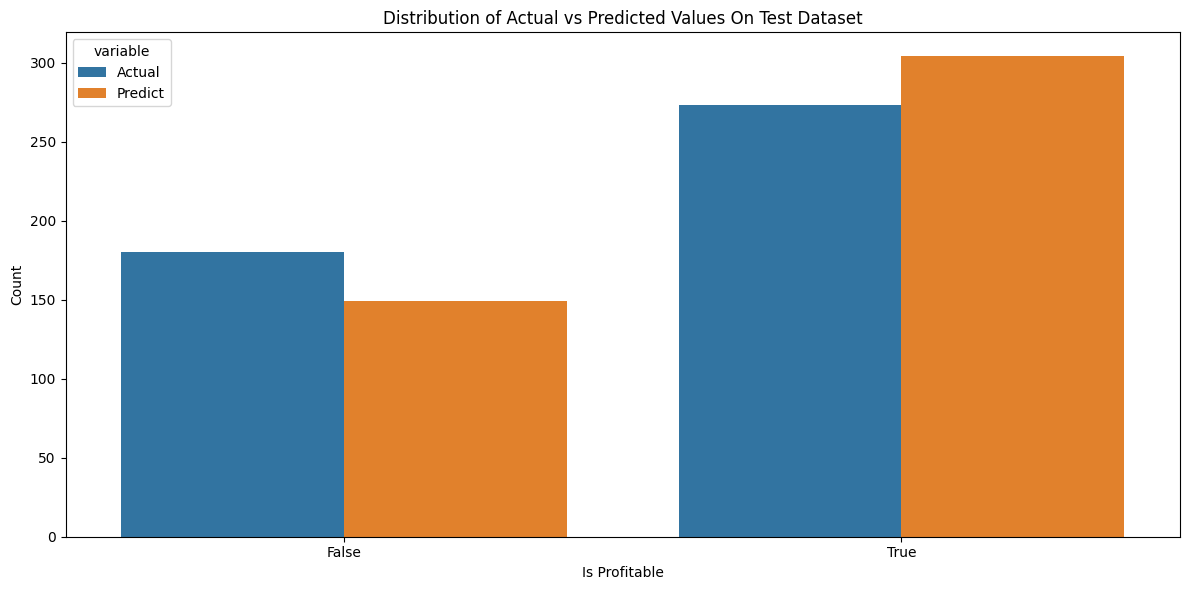

In [53]:
pred_y_test = best_pipeline.predict(test_X)
pred_y_valid = best_pipeline.predict(valid_X)
accuracy_valid = accuracy_score(valid_y, pred_y_valid)
accuracy_test = accuracy_score(test_y, pred_y_test)
print("Test Accuracy On Validation Dataset:", accuracy_valid)
print("Test Accuracy On Test Dataset:", accuracy_test)

plt.figure(figsize=(12, 6))
sns.countplot(data=pd.melt(pd.DataFrame({
    'Actual': test_y,
    'Predict': pred_y_test
})), x='value', hue='variable')

plt.title('Distribution of Actual vs Predicted Values On Test Dataset')
plt.xlabel('Is Profitable')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Kết luận


**1. Phân tích tương quan:**

*   `vote_count`, `vote_average`, và `years_from_release` (phim càng mới) có tương quan thuận với khả năng sinh lời (`is_profitable`).
*   `budget` có tương quan không đáng kể.
*   Một số thể loại phim (`genre_...`) có tương quan yếu, cả thuận và nghịch, với `is_profitable`.

**2. Mô hình:**

*   **Logistic Regression**, **Random Forest**, và **Gradient Boosting** được thử nghiệm và tinh chỉnh siêu tham số.
*   **Biểu đồ 1 (Confusion Matrix - Logistic Regression):**
    *   Mô hình Logistic Regression (sau tinh chỉnh) dự đoán đúng 114 trường hợp không sinh lời (True Negative) và 218 trường hợp sinh lời (True Positive).
    *   Mô hình dự đoán sai 73 trường hợp không sinh lời thành có lời (False Positive) và 56 trường hợp có lời thành không lời (False Negative).
* **Biểu đồ 2 (Distribution of Actual vs Predicted Values):**
    *   Phân phối giá trị thực tế và giá trị dự đoán của mô hình Logistic Regression khá tương đồng.
*   **Biểu đồ 3 (Model Performance Metrics):**
    *   Cả ba mô hình đều cho kết quả tốt, vượt qua ngưỡng "Good Performance Threshold" (0.7).
    *   `Random Forest` và `Gradient Boosting` có độ chính xác (Accuracy), Precision, Recall, và F1-Score nhỉnh hơn một chút so với `Logistic Regression`.
*   **Biểu đồ 4 (Distribution of Actual vs Predicted Values On Test Dataset):**
    *   Phân phối giá trị thực tế và giá trị dự đoán trên tập test cho thấy mô hình dự đoán giá trị "True" (có lợi nhuận) tốt hơn "False" (không có lợi nhuận). Có sự chênh lệch đáng kể giữa giá trị dự đoán và thực tế cho lớp "False".

**3. Lựa chọn mô hình:**

*   `Pipeline` kết hợp `StandardScaler` và mô hình **`Gradient Boosting`** (đã tinh chỉnh) được chọn là mô hình tốt nhất dựa trên `GridSearchCV`.

**4. Kết luận chung:**

*   Mô hình **`Gradient Boosting`** (sau tinh chỉnh), kết hợp với `StandardScaler`, cho thấy hiệu suất tốt nhất trong việc dự đoán khả năng sinh lời của phim dựa trên các đặc trưng đã cho.
*   Mô hình có khả năng khái quát hóa tốt, thể hiện qua hiệu suất tốt trên cả tập validation và tập test.
*   `vote_count`, `vote_average`, và `years_from_release` là những yếu tố quan trọng ảnh hưởng đến khả năng sinh lời.
